30758 districtings found
30613 unique districtings found
--- 68.82011389732361 seconds ---
--- 77.93492102622986 seconds ---


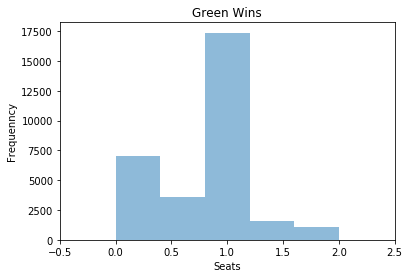

In [3]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
n by n toy examples with m districts where m | n^2

Jan 30 revisions

You can run for different scenarios by modifying the variables
    n                   grid size is n x n
    m                   number of districts
    num_proposals       number of swaps between districts to try in building new districting
    party_file      a csv file that contains the party assignment for each cells, either 0 or 1
                        the program counts the number of seats won by party 1
    district_file   a csv file that contains the initial district assignment of each cell
    last_district_outfile       csv file that contains the last districting found


Based on code by Christy Graves
Modified by Tommy Ratliff

Code should be fairly easily generalized to work for any graph
"""

import math
import numpy as np
import copy
import random
from collections import Counter
import csv # used for reading initial districting and party assignments file
import pandas as pd
from matplotlib import pyplot as plt
import networkx as nx


import time #checking for runtime
start_time = time.time()

def create_graph_n_by_n(n):
    G=nx.Graph()
    for i in range(n**2):
        # compute index of my neighbor in each direction (north, northeast, etc.)
        # the nodes are indexed by row first (1st row is indices 0 through 9, 2nd row is indices 10 through 19, etc.)
        my_row=int(math.floor(i/n))
        my_column=i%n
        west=i-1
        east=i+1
        north=i-n
        south=i+n
        northwest=i-n-1
        northeast=i-n+1
        southwest=i+n-1
        southeast=i+n+1
        if(my_row>0):
            G.add_edge(i,north)
        if(my_row<(n-1)):
            G.add_edge(i,south)
        if(my_column>0):
            G.add_edge(i,west)
        if(my_column<(n-1)):
            G.add_edge(i,east)
        if(my_row>0 and my_column>0):
            G.add_edge(i,northwest)
        if(my_row>0 and my_column<(n-1)):
            G.add_edge(i,northeast)
        if(my_row<(n-1) and my_column>0):
            G.add_edge(i,southwest)
        if(my_row<(n-1) and my_column<(n-1)):
            G.add_edge(i,southeast)
    return G

#### Used to read Districting and Party Affiliation files
def read_csv(csv_file, data):
    # Read values from csv_file  into table
    #  then flatten table and convert to integer values
    infile = open(csv_file, 'r')
    table = [row for row in csv.reader(infile)]
    infile.close()
    flat_list = [item for sublist in table for item in sublist]
    # may be necessary to clear out BOM if csv file exported from Excel
    flat_list[0] = flat_list[0].replace('\xef\xbb\xbf', '')
    flat_list[0] = flat_list[0].replace('\ufeff', '')
    data = list(map(int, flat_list))
    return data

# Swap districts in district list
def swap_districts(districting1,r1,r2):
    tmp=districting1[r1]
    districting1[r1]=districting1[r2]
    districting1[r2]=tmp

# Remove all edges connected to vertex nd in graph Gr
def remove_all_edges(Gr,nd):
    list_neighbors=list(nx.all_neighbors(Gr, nd))
    for q in list_neighbors:
        Gr.remove_edge(nd,q)

# Look at all possible edges to nd in graph Gfull
# and add those to graph Gr that connect nd to another vertex
# in the same district based on labeling in districting1
def add_district_edges(Gr,nd,districting1,Gfull):
        list_neighbors=list(nx.all_neighbors(Gfull,nd))
        for q in list_neighbors:
            if(districting1[nd]==districting1[q]):
                Gr.add_edge(nd,q)

if __name__ == '__main__':
    num_proposals=100000 # number of proposal steps to try
    n=18 # length/width of grid
    m=6 # number of districts
#    party_file="18x18_parties_uniform.csv"  # csv file that contains party assignments
#    party_file="18x18_parties_striped.csv"  # csv file that contains party assignments
#    party_file="18x18_parties_clustered.csv"  # csv file that contains party assignments

    district_file="/home/hannah/miniconda3/envs/vrdi/n_by_n/18x18_districts_rectangles.csv" # csv file that contains district assignments
    districtings_outfile="/home/hannah/miniconda3/envs/vrdi/n_by_n/run5_18x18_all_districtings.csv" # csv file that contains the last districting found
    unique_districtings_outfile="/home/hannah/miniconda3/envs/vrdi/n_by_n/run5_18x18_unique_districtings.csv" # csv file that contains the last districting found

    district_size=n*n / m #number of cells in each district
    G=create_graph_n_by_n(n)
    all_edges=list(G.edges())
    num_G_edges=len(all_edges) # number of edges

    districtings=[]
    districting=[]
    districting=read_csv(district_file,districting)
    tmp_districting=copy.deepcopy(districting) # Not certain if this is strictly necessary
    districtings.append(tmp_districting)

    # G3 is the subgraph of G where edges connect nodes in the same district
    # G3 should have m connected components, one corresponding to each district
    G3=G.copy()
    G3_edges=list(G3.edges())
    for edge in G3_edges:
        a=edge[0]
        b=edge[1]
        if districting[a]!=districting[b]:
            G3.remove_edge(edge[0],edge[1])

    for k in range(num_proposals):
        # 'districting' is the current districting plan
        # propose a change to the current districting
        # What I am doing here is choosing a random edge until I find a
        # conflicted edge
        conflicted_edge_not_found=True
        while(conflicted_edge_not_found):
            r=random.randint(0,num_G_edges-1)
            edge=all_edges[r]
            r_a=edge[0]
            r_b=edge[1]
            if(districting[r_a]!=districting[r_b]):
                conflicted_edge_not_found=False

        # TR modification:
        # Change the graph G3 directly rather than building from scratch each iteration
        # We want to swap districts for r_a and r_b
        #       Then remove all edges connected to r_a or r_b
        #       Then add edges to r_a or r_b based on districting
        swap_districts(districting,r_a,r_b)
        remove_all_edges(G3,r_a)
        remove_all_edges(G3,r_b)
        add_district_edges(G3,r_a,districting,G)
        add_district_edges(G3,r_b,districting,G)

        # If the new districting is valid, then add it to the list of districtings
        # Otherwise, undo the changes to G3 and revert to previous state
        if(nx.number_connected_components(G3)==m):
            tmp_districting=copy.deepcopy(districting) # I believe this is necessary because of the way python deals with arrays
            districtings.append(tmp_districting)
        else:
            swap_districts(districting,r_a,r_b)
            remove_all_edges(G3,r_a)
            remove_all_edges(G3,r_b)
            add_district_edges(G3,r_a,districting,G)
            add_district_edges(G3,r_b,districting,G)

    # Write all districtings to csv file
    outfile = open(districtings_outfile,"w")
    writer=csv.writer(outfile,delimiter=',',quoting=csv.QUOTE_NONE)
    for j in range(len(districtings)):
        writer.writerow(districtings[j])
    outfile.close()

    # Now write out unique districtings
    districtings=sorted(districtings)
    unique_districtings=[]
    for j in range(len(districtings)-1):
        if districtings[j]!=districtings[j+1]:
            tmp_districting=copy.deepcopy(districtings[j]) # Not certain if this is necessary
            unique_districtings.append(tmp_districting)
    tmp_districting=copy.deepcopy(districtings[j+1]) # Not certain if this is necessary
    unique_districtings.append(tmp_districting)

    outfile = open(unique_districtings_outfile,"w")
    writer=csv.writer(outfile,delimiter=',',quoting=csv.QUOTE_NONE)
    for j in range(len(unique_districtings)):
        writer.writerow(unique_districtings[j])
    outfile.close()

#    plt.hist(num_party1_seats) # the histogram it makes is ugly, but you get the idea
    print ("%d districtings found" %len(districtings))
    print ("%d unique districtings found" %len(unique_districtings))
    print("--- %s seconds ---" % (time.time() - start_time)) # Show runtime
    #plt.show()
    #   Just for now
    
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
party1_districting_counts.py

Reads
    *_parties_*.csv     contains distribution of party1 in grid
    *_districtings.csv  contains districtings, one per row

outputs

    outfile.csv containing one row per districting of form

        District #, District party1 totals, District party 1 seats, Total party 1 seats

    e.g., in 18x18 with 6 districts, could be

        0,      5, 18, 27, 30, 15, 0,       0, 0, 0.5, 1, 0, 0,     1.5


"""


#### Used to read *_parties_*.csv file
def read_csv(csv_file, data):
    # Read values from csv_file  into table
    #  then flatten table and convert to integer values
    infile = open(csv_file, 'r')
    table = [row for row in csv.reader(infile)]
    infile.close()
    flat_list = [item for sublist in table for item in sublist]
    # may be necessary to clear out BOM if csv file exported from Excel
    flat_list[0] = flat_list[0].replace('\xef\xbb\xbf', '')
    flat_list[0] = flat_list[0].replace('\ufeff', '')
    data = list(map(int, flat_list))
    return data

if __name__ == '__main__':
    districtings_file="run5_18x18_unique_districtings.csv"
#    districtings_file="toy_districtings.csv"
#    parties_file="18x18_parties_uniform.csv"
#    parties_file="18x18_parties_striped.csv"
    parties_file="18x18_parties_clustered.csv"

    counts_outfile="run5_18x18_unique_clustered_party_counts.csv"

    # Read file containing party assignment for each district
    party_assignment=[]
    party_assignment=read_csv(parties_file,party_assignment)

    # Read through districtings_file into districtings[]
    districtings=[]
    infile = open(districtings_file, 'r')
    districtings = [row for row in csv.reader(infile)]
    infile.close()

    # Determine number of districts
    m=len(set(districtings[0]))
    district_size=18*18/6       # Can change later

    # Count party 1 seats and write out file
    outfile = open(counts_outfile,"w")
    writer=csv.writer(outfile,delimiter=',',quoting=csv.QUOTE_NONE)

    data = []

    for k in range(len(districtings)):
        party_counts=np.zeros(m,dtype=np.int)

        districting=list(map(int, districtings[k]))
        for i in range(len(districting)):
            party=party_assignment[i]
            district=districting[i]
            party_counts[district]+=party       # Adding 0 or 1 to party_counts

        party_wins=np.zeros(m,dtype=np.single)

        for i in range(m):
            if party_counts[i]>district_size/2:
                party_wins[i]+=1
            elif party_counts[i]==district_size/2:
                party_wins[i]+=0.5

        total_wins=[sum(party_wins)]
        
        data.append(total_wins[0])

        outrow=[k]+list(party_counts)+list(party_wins)+list(total_wins)

        writer.writerow(outrow)

    outfile.close()



    print("--- %s seconds ---" % (time.time() - start_time)) # Show runtime
     
#bins = np.arange(0,3) # fixed bin size

plt.xlim([min(data)-0.5, max(data)+0.5])

plt.hist(data, bins=5, alpha=0.5)
plt.title('Green Wins')
plt.xlabel('Seats')
plt.ylabel('Frequenncy')

plt.show()